# Retrieving The Data

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv("train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Preprocess

In [4]:
from tensorflow.keras.layers import TextVectorization

X = df['comment_text'] # our samples 
y = df[df.columns[2:]].values # our labels

MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [5]:
vectorizer.adapt(X.values) # Learning the vocabulary from the training data

In [6]:
vectorized_text = vectorizer(X.values) # Converts all comments into numerical token sequences.

In [7]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y)) # create a dataset: [vectorized_text][y values]
dataset = dataset.cache() # stores the data in cache to speed up the training
dataset = dataset.shuffle(160000) # shuffles the samples to prevent the model learning patterns in the order of data
dataset = dataset.batch(16) # encapsulate 16 samples for one group/batch for faster training
dataset = dataset.prefetch(8) # ensures training never waits for data by loading the next batches in advance

In [8]:
train = dataset.take(int(len(dataset)*.7)) # 70% training
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2)) # 20% for validation for detecting overfitting
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1)) # 10# for test

# Create Sequential Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
model = Sequential()
# Create the embedding layer - converts words into vectors
model.add(Embedding(MAX_FEATURES+1, output_dim = 32, input_length = 1800))
# Bidirectional LSTM Layer captures relationships from both past & future words
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer - Multi-label classification
model.add(Dense(6, activation='sigmoid'))

c:\Users\aviad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
# Since each label is independent, binary classification is used for each category
# Adaptive learning rate for faster and efficient training
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
# Initializing of all layers for 1800 fixed sequence length (tokens per comment)
model.build(input_shape=(None, 1800))  # Batch size is flexible (None), sequence length is 1800

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2519s 360ms/step - loss: 0.0830 - val_loss: 0.0464
Epoch 2/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2539s 360ms/step - loss: 0.0446 - val_loss: 0.0388
Epoch 3/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2915s 413ms/step - loss: 0.0406 - val_loss: 0.0368
Epoch 4/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2526s 360ms/step - loss: 0.0360 - val_loss: 0.0310
Epoch 5/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3812s 546ms/step - loss: 0.0315 - val_loss: 0.0288
Epoch 6/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1476s 211ms/step - loss: 0.0283 - val_loss: 0.0272
Epoch 7/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1471s 211ms/step - loss: 0.0254 - val_loss: 0.0215
Epoch 8/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1462s 209ms/step - loss: 0.0231 - val_loss: 0.0194
Epoch 9/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1462s 209ms/step - loss: 0.0199 - val_loss: 0.0174
Epoch 10/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1468s 210ms/step - loss: 0.0184 - val_loss: 0.0142


<Figure size 800x500 with 0 Axes>

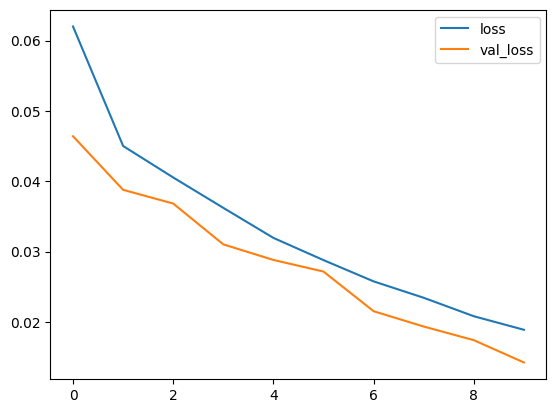

In [13]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Make Predictions

In [30]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [14]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
res = model.predict(np.array([input_text]))
print(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
[[0.99947566 0.58028436 0.99616444 0.07259331 0.93642896 0.16910817]]


In [15]:
(res > 0.5).astype(int)

array([[1, 1, 1, 0, 1, 0]])

In [16]:
batch_X, batch_y = test.as_numpy_iterator().next() # extracting one batch from the test dataset 

In [17]:
(model.predict(batch_X) > 0.5).astype(int) # predicting results from all comments in the batch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]])

# Evaluate Model

In [18]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
# Initialize metrics
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [19]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions into 1D arrays for metrics
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

In [20]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9130434989929199, Recall:0.9263854622840881, Accuracy:0.5396188497543335


# Testing

In [21]:
import tensorflow as tf

In [22]:
model.save('toxicity.h5.keras')

In [23]:
model = tf.keras.models.load_model('toxicity.h5.keras')

In [24]:
input_str = vectorizer('I hate you!')

In [25]:
res = model.predict(np.array([input_str]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


In [26]:
res

array([[0.8940334 , 0.00112108, 0.01178915, 0.01275482, 0.17782693,
        0.02414824]], dtype=float32)

In [27]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    output = {}
    for idx, col in enumerate(df.columns[2:]): 
        output[col] = results[0][idx] > 0.5  
    
    return output

In [33]:
# Test with an example comment
comment = "You're so ugly, I hate you"
result = score_comment(comment)

print("Toxicity Analysis Result:")
for label, value in result.items():
    print(f"{label}: {'Yes' if value else 'No'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Toxicity Analysis Result:
toxic: Yes
severe_toxic: No
obscene: No
threat: No
insult: Yes
identity_hate: No
